In [1]:
!pip install -qq ultralytics torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Path to dataset files: /kaggle/input/celeba-dataset
Device: cuda


In [11]:
# download heatmaps
#!curl -L -o heatmaps.h5 https://huggingface.co/datasets/RiccardoCarraro/heatmaps/resolve/main/heatmaps_10k.h5

# for 30k dataset
#!curl -L -o heatmaps.h5 https://huggingface.co/datasets/RiccardoCarraro/heatmaps/resolve/main/heatmaps_30k.h5

#Uncomment following line to download full 50k heatmaps
!curl -L -o heatmaps.h5 https://huggingface.co/datasets/RiccardoCarraro/heatmaps/resolve/main/heatmaps.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1098  100  1098    0     0   4526      0 --:--:-- --:--:-- --:--:--  4537
100  904M  100  904M    0     0   179M      0  0:00:05  0:00:05 --:--:--  204M


## Check Images

/kaggle/input/celeba-dataset
/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg


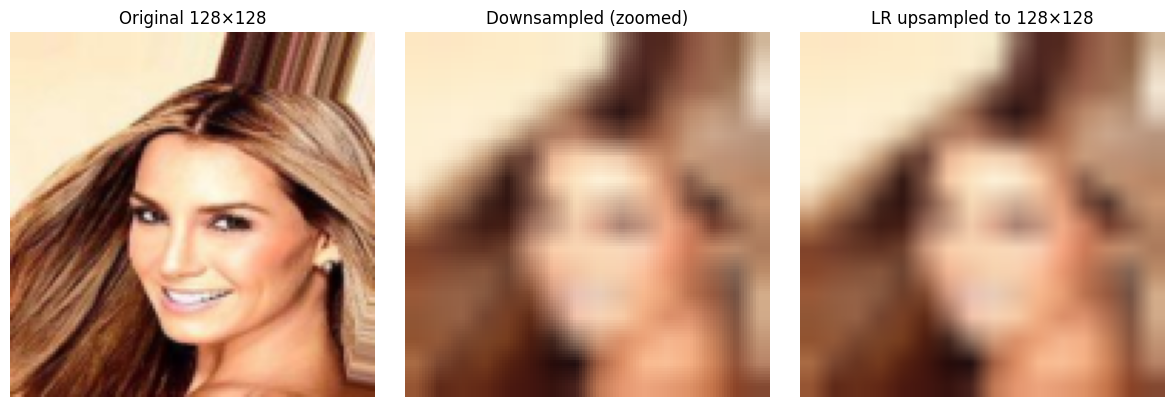

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Load one sample image (using PIL)
print(path)
img_path = os.path.join(path, "img_align_celeba/img_align_celeba/000001.jpg")
print(img_path)
img = Image.open(img_path).convert('RGB')

# Define transformations
to_128 = T.Resize((128, 128), interpolation=InterpolationMode.BILINEAR)
to_16   = T.Resize((16, 16), interpolation=InterpolationMode.BILINEAR)
to_tensor = T.ToTensor()
to_pil = T.ToPILImage()

# Resize to 128×128 as HR ground truth
img_128 = to_128(img)

# Kim-style degradation: 128 → 16 using bilinear downsampling
img_16 = to_16(img_128)

# Upsample degraded image back to 128x128 to show what the network receives
img_16_up = to_128(img_16)

# Display original, degraded, and upsampled LR
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_128)
axs[0].set_title("Original 128×128")

axs[1].imshow(to_128(img_16), interpolation='nearest')
axs[1].set_title("Downsampled (zoomed)")

axs[2].imshow(img_16_up)
axs[2].set_title("LR upsampled to 128×128")

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Show heatmaps for checking

/tmp/ipython-input-2509830121.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


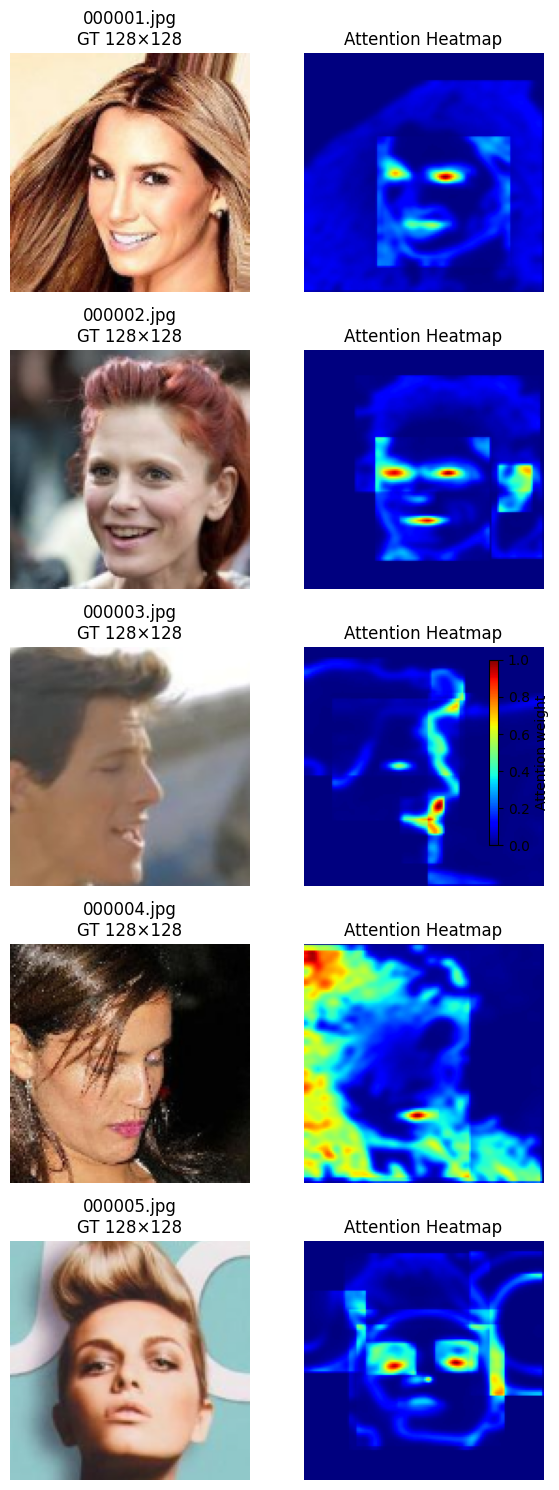

In [5]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ── CONFIG ──────────────────────────────────────────────────────────────────────
IMG_DIR   = os.path.join(path, "img_align_celeba/img_align_celeba")
HDF5_PATH = './heatmaps.h5'
N_SHOW    = 5

# ── 1) LOAD FIRST N_SHOW HEATMAPS ───────────────────────────────────────────────
with h5py.File(HDF5_PATH, "r") as f:
    heatmaps = f["heatmaps"][:N_SHOW]   # shape (N_SHOW, 128,128)

# ── 2) GET FIRST N_SHOW IMAGE FILENAMES ─────────────────────────────────────────
fnames = sorted(os.listdir(IMG_DIR))[:N_SHOW]

# ── 3) PLOT GRID: N_SHOW rows × 2 cols ──────────────────────────────────────────
fig, axes = plt.subplots(N_SHOW, 2, figsize=(6, 3 * N_SHOW))
for i, fn in enumerate(fnames):
    # a) load & center‐crop to square → resize to 128×128
    img = cv2.imread(os.path.join(IMG_DIR, fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    side = min(h, w)
    y0, x0 = (h-side)//2, (w-side)//2
    crop = img[y0:y0+side, x0:x0+side]
    gt128 = cv2.resize(crop, (128,128), interpolation=cv2.INTER_LINEAR)

    # b) plot ground‐truth patch
    ax = axes[i, 0]
    ax.imshow(gt128)
    ax.set_title(f"{fn}\nGT 128×128")
    ax.axis("off")

    # c) plot heatmap
    ax = axes[i, 1]
    im = ax.imshow(heatmaps[i], cmap="jet", vmin=0, vmax=1)
    ax.set_title("Attention Heatmap")
    ax.axis("off")

# ── 4) ADD A SHARED COLORBAR ────────────────────────────────────────────────────
cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    fraction=0.02, pad=0.04)
cbar.set_label("Attention weight")

plt.tight_layout()
plt.show()


# Data loader class from Kim et al
Minor changes were applied only on the hard-coded string that were present. Also, the original dataloader used a .txt file for 'list_eval_partition': the code had been adapted to use the .csv version. Adapted to load heatmaps too

[Repo link](https://github.com/DeokyunKim/Progressive-Face-Super-Resolution/blob/master/dataloader.py)

In [12]:
import h5py
import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from os.path import join, splitext
from PIL import Image
import csv
import numpy as np

class CelebDataSet(Dataset):
    """
    CelebA dataset with optional landmark-heatmap loading from HDF5.

    Returns: (x2, x4, hr, lr, heatmap)
      - x2: 32×32 target tensor
      - x4: 64×64 target tensor
      - hr: 128×128 target tensor
      - lr: 16×16 input tensor
      - heatmap: 1×128×128 float tensor
    """
    def __init__(
        self,
        data_path: str = './dataset/',
        state: str = 'train',
        data_augmentation: bool = False,
        heatmap_h5: str = None,
    ):
        self.main_path = data_path
        self.state = state
        self.data_augmentation = data_augmentation
        self.img_path = join(self.main_path, 'img_align_celeba/img_align_celeba/')
        self.eval_partition_path = join(self.main_path, 'list_eval_partition.csv')

        # load train/val/test split
        train_list, val_list, test_list = [], [], []
        with open(self.eval_partition_path, 'r') as f:
            reader = csv.reader(f)
            for fname, split in reader:
                fname, split = fname.strip(), split.strip()
                if split == '0':
                    train_list.append(fname)
                elif split == '1':
                    val_list.append(fname)
                else:
                    test_list.append(fname)

        if state == 'train':
            self.image_list = sorted(train_list)
        elif state == 'val':
            self.image_list = sorted(val_list)
        else:
            self.image_list = sorted(test_list)

        # transforms
        if state=='train' and data_augmentation:
            self.pre_process = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.CenterCrop((178,178)),
                transforms.Resize((128,128)),
                transforms.RandomRotation(
                    20,
                    interpolation=InterpolationMode.BILINEAR
                ),
                transforms.ColorJitter(0.4,0.4,0.4,0.1)
            ])
        else:
            self.pre_process = transforms.Compose([
                transforms.CenterCrop((178,178)),
                transforms.Resize((128,128)),
            ])

        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])
        self.down64 = transforms.Resize((64,64))
        self.down32 = transforms.Resize((32,32))
        self.down16 = transforms.Resize((16,16))

        # ACTUALLY load heatmaps into memory
        if heatmap_h5:
            with h5py.File(heatmap_h5, 'r') as h5_file:
                # Load the entire heatmap dataset into RAM
                self.heatmaps = np.array(h5_file['heatmaps'])  # Shape: (N, 128, 128)
        else:
            self.heatmaps = None

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        # load image
        fname = self.image_list[index]
        img = Image.open(join(self.img_path, fname)).convert('RGB')
        img = self.pre_process(img)

        # build multi-scale
        x4 = self.down64(img)    # 64x64
        x2 = self.down32(x4)     # 32x32
        lr = self.down16(x2)     # 16x16

        # to tensor
        hr_tensor = self.totensor(img)
        x4_tensor = self.totensor(x4)
        x2_tensor = self.totensor(x2)
        lr_tensor = self.totensor(lr)

        # load heatmap (already 128×128) - NOW FROM MEMORY!
        if self.heatmaps is not None:
            hm = self.heatmaps[index]              # numpy array (128,128) FROM MEMORY
            heat = torch.from_numpy(hm.copy()).unsqueeze(0)  # (1,128,128)
        else:
            heat = torch.zeros(1,128,128)

        return x2_tensor, x4_tensor, hr_tensor, lr_tensor, heat

## Checking data loader

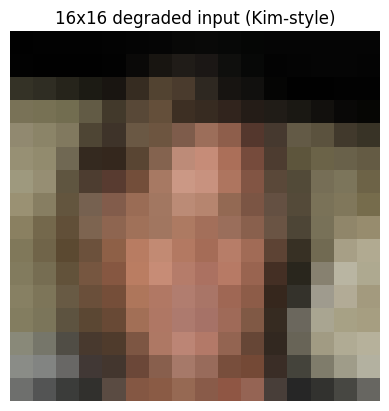

In [13]:
from torch.utils.data import DataLoader

dataset = CelebDataSet(
    data_path=path,
    state='train'
)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Visualize a sample
import matplotlib.pyplot as plt

x2, x4, target, inp, _ = next(iter(loader))  # tensors: [B, C, H, W]

# Unnormalize and convert to PIL to display
def show_img(tensor_img):
    img = tensor_img.permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.imshow(img.numpy())
    plt.axis('off')

show_img(inp[0])
plt.title("16x16 degraded input (Kim-style)")
plt.show()


# Model

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Efficient DoubleConv with LeakyReLU activation."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    """Upsampling followed by DoubleConv, with skip connection."""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UpLearn(nn.Module):
    """Simpler learned upsampling block."""
    def __init__(self, ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ch, ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.up(x)

class SuperResolutionUNet(nn.Module):
    """Efficient U-Net super-resolution (16x16 → 128x128)."""
    def __init__(self, in_channels=3, base_filters=32, out_channels=3):
        super().__init__()
        # Encoder (depth reduced)
        self.enc1 = DoubleConv(in_channels, base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck (lighter)
        self.bottleneck = DoubleConv(base_filters*4, base_filters*8)

        # Decoder
        self.up3 = UpBlock(base_filters*8, base_filters*4, base_filters*4)
        self.up2 = UpBlock(base_filters*4, base_filters*2, base_filters*2)
        self.up1 = UpBlock(base_filters*2, base_filters, base_filters)

        # Learned upsampling (simplified, 16→32→64→128)
        self.up_learn1 = UpLearn(base_filters)
        self.up_learn2 = UpLearn(base_filters)
        self.up_learn3 = UpLearn(base_filters)

        # Final projection
        self.final_conv = nn.Conv2d(base_filters, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        d3 = self.up3(b, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)

        u1 = self.up_learn1(d1)  # 32x32
        u2 = self.up_learn2(u1)  # 64x64
        u3 = self.up_learn3(u2)  # 128x128

        out = self.final_conv(u3)
        up_input = F.interpolate(x, size=out.shape[2:], mode='bilinear', align_corners=True)
        return out + up_input

# Training

Total parameters:     7,979,843
Trainable parameters: 7,979,843


Epoch 1/200: 100%|██████████| 391/391 [04:28<00:00,  1.46it/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 001 ‒ pix=3.3997e-02  attn=1.1501e-02  perc=1.9140e+01  comb=4.1248e-02


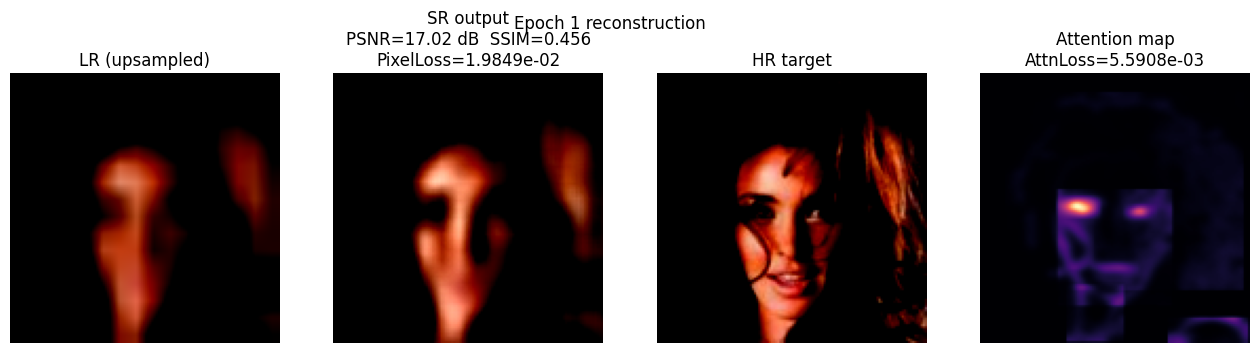

Epoch 2/200:  43%|████▎     | 168/391 [01:56<02:33,  1.45it/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import vgg16
from torchmetrics.functional import structural_similarity_index_measure as ssim


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(pretrained=True).features.eval()
        # qui è cruciale iterare sui parametri, non sui moduli
        for p in vgg.parameters():
            p.requires_grad = False

        # estraiamo i tre slice
        self.slice1 = nn.Sequential(*vgg[:4])   # fino a conv1_2
        self.slice2 = nn.Sequential(*vgg[4:9])  # fino a conv2_2
        self.slice3 = nn.Sequential(*vgg[9:16]) # fino a conv3_3

        # buffers per la normalizzazione
        self.register_buffer('mean', torch.tensor([0.485,0.456,0.406]).view(1,3,1,1))
        self.register_buffer('std',  torch.tensor([0.229,0.224,0.225]).view(1,3,1,1))

    def normalize(self, x):
        # da [-1,1] a [0,1] poi standard VGG
        x = (x + 1) / 2
        return (x - self.mean) / self.std

    def forward(self, sr, hr):
        sr_n, hr_n = self.normalize(sr), self.normalize(hr)
        f1_sr, f1_hr = self.slice1(sr_n), self.slice1(hr_n)
        f2_sr, f2_hr = self.slice2(f1_sr), self.slice2(f1_hr)
        f3_sr, f3_hr = self.slice3(f2_sr), self.slice3(f2_hr)
        return (
            F.mse_loss(f1_sr, f1_hr)
          + F.mse_loss(f2_sr, f2_hr)
          + F.mse_loss(f3_sr, f3_hr)
        )

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters:     {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    return total, trainable

# ——————————— Settings ———————————
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path  = path
heat_h5    = './heatmaps.h5'
batch_size = 128
num_epochs = 200
lr         = 1e-4
NUM_SAMPLES = 50000

os.makedirs('./checkpoints', exist_ok=True)

# ——————————— Data ———————————
train_ds = CelebDataSet(
    data_path=data_path,
    state='train',
    heatmap_h5=heat_h5
)

small_ds = Subset(train_ds, list(range(NUM_SAMPLES)))

train_loader = DataLoader(
    small_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# ——————————— Model, Loss, Optimizer ———————————
model      = SuperResolutionUNet(in_channels=3, base_filters=64, out_channels=3).to(device)
count_parameters(model)

pixel_crit = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
perceptual_loss = VGGPerceptualLoss().to(device)

# weight for heatmap term
w_heatmap = 1.0

def attention_loss(sr, hr, heat, eps=1e-6):
    """
    Implements Eq. (1) from Kim et al. (FAN-based attention).
    sr, hr : (B,3,H,W) — super-resolved & ground-truth images in [−1,1] or [0,1]
    heat   : (B,1,H,W) — raw FAN heatmap; we will min-max normalize it to [0,1]
    """
    # 1) Per-sample min-max normalize the heatmap into [0,1]
    h_min = heat.flatten(1).min(dim=1)[0].view(-1,1,1,1)
    h_max = heat.flatten(1).max(dim=1)[0].view(-1,1,1,1)
    heat_norm = (heat - h_min) / (h_max - h_min + eps)

    # 2) Compute per-pixel L1 difference
    diff = (sr - hr).abs()                    # (B,3,H,W)

    # 3) Broadcast the attention map across channels and weight
    w = heat_norm.expand_as(diff)             # (B,3,H,W)
    loss = (w * diff).mean()                  # average over B×C×H×W

    return loss


avg_pix  = 0.044206276535987854
avg_attn = 0.005226159002631903
avg_perc = 17.73185920715332

weight_pixel      = 1.0
weight_attention  = avg_pix  / avg_attn    # ≃ 0.0442 / 0.00523  ≃ 8.46
weight_perceptual = avg_pix  / avg_perc    # ≃ 0.0442 / 17.73   ≃ 0.0025

warmup_epochs = 20
max_weight_attention  = weight_attention
max_weight_perceptual = weight_perceptual

pixel_losses      = []
attention_losses  = []
perceptual_losses = []
combined_losses   = []
epoch_list        = []

# ——————————— Training Loop ———————————
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    running_pix, running_attn, running_perc, running_comb = 0., 0., 0., 0.
    n_batches = 0
    ramp = min(1.0, epoch / warmup_epochs)

    w_attn = ramp * max_weight_attention
    w_perc = ramp * max_weight_perceptual

    for x2, x4, hr, lr_img, heat in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        # lr_img: (B,3,16,16), hr: (B,3,128,128), heat: (B,1,128,128)
        lr_img = lr_img.to(device)
        hr     = hr.to(device)
        heat   = heat.to(device)

        # forward
        sr = model(lr_img)            # → (B,3,128,128)

        # losses
        l_pix  = pixel_crit(sr, hr)
        l_attn = attention_loss(sr, hr, heat)
        l_perc = perceptual_loss(sr, hr)

        loss = (
            weight_pixel      * l_pix
          + w_attn            * l_attn
          + w_perc            * l_perc
        )

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        running_pix  += l_pix.item()
        running_attn += l_attn.item()
        running_perc += l_perc.item()
        running_comb += loss.item()
        n_batches    += 1

    #compute epoch averages
    avg_pix  = running_pix  / n_batches
    avg_attn = running_attn / n_batches
    avg_perc = running_perc / n_batches
    avg_comb = running_comb / n_batches

    # append to history
    pixel_losses.     append(avg_pix)
    attention_losses. append(avg_attn)
    perceptual_losses.append(avg_perc)
    combined_losses.  append(avg_comb)
    epoch_list.       append(epoch)
    print(f"Epoch {epoch:03d} ‒ pix={avg_pix:.4e}  attn={avg_attn:.4e}  perc={avg_perc:.4e}  comb={avg_comb:.4e}")

    # ——— plot every 10 epochs ———
    if epoch % 10 == 0:
      plt.figure(figsize=(8,6))
      plt.plot(epoch_list, pixel_losses,      label='Pixel')
      plt.plot(epoch_list, attention_losses,  label='Attention')
      plt.plot(epoch_list, perceptual_losses, label='Perceptual')
      plt.plot(epoch_list, combined_losses,   label='Combined')
      plt.yscale('log')
      plt.xlabel('Epoch')
      plt.ylabel('Loss (log scale)')
      plt.title(f'Loss curves up to epoch {epoch}')
      plt.legend()
      plt.grid(True, which='both', ls='--')
      plt.show()


    # ——— Visualize one sample ———
    model.eval()
    with torch.no_grad():
        # grab the last‐batch sample directly as CHW tensors on GPU
        lr_tensor = lr_img[0]  # (3,16,16) on GPU
        hr_tensor = hr[0]      # (3,128,128) on GPU
        heat_tensor = heat[0]  # (1,128,128) on GPU
        sr_tensor = sr[0]      # (3,128,128) on GPU

        # 1) compute losses & metrics on GPU (BCHW)
        sr_b = sr_tensor.unsqueeze(0)     # (1,3,128,128)
        hr_b = hr_tensor.unsqueeze(0)     # (1,3,128,128)
        heat_b = heat_tensor.unsqueeze(0) # (1,1,128,128)

        # Pixel & attention loss (just to display)
        pix_loss = pixel_crit(sr_b, hr_b).item()
        attn_loss = attention_loss(sr_b, hr_b, heat_b).item()

        # PSNR
        mse_val = F.mse_loss(sr_b, hr_b, reduction='mean')
        psnr_val = 10.0 * torch.log10(1.0 / mse_val).item()

        # SSIM (expects BCHW)
        ssim_val = ssim(sr_b, hr_b, data_range=1.0).item()

        # 2) prepare for plotting (move to CPU and permute to HWC)
        lr_up = F.interpolate(
            lr_tensor.unsqueeze(0),
            size=hr_tensor.shape[1:], mode='bilinear', align_corners=False
        ).squeeze(0).cpu()                 # (3,128,128)
        lr_up = lr_up.permute(1,2,0).clamp(0,1)  # (128,128,3)

        sr_img = sr_tensor.cpu().permute(1,2,0).clamp(0,1)    # (128,128,3)
        hr_img = hr_tensor.cpu().permute(1,2,0).clamp(0,1)    # (128,128,3)
        heat_img = heat_tensor.cpu().squeeze(0).numpy()      # (128,128)

    # 3) plot
    fig, axes = plt.subplots(1,4, figsize=(16,4))

    axes[0].imshow(lr_up)
    axes[0].set_title("LR (upsampled)")
    axes[0].axis('off')

    axes[1].imshow(sr_img)
    axes[1].set_title(
        "SR output\n"
        f"PSNR={psnr_val:.2f} dB  SSIM={ssim_val:.3f}\n"
        f"PixelLoss={pix_loss:.4e}"
    )
    axes[1].axis('off')

    axes[2].imshow(hr_img)
    axes[2].set_title("HR target")
    axes[2].axis('off')

    axes[3].imshow(heat_img, cmap='magma')
    axes[3].set_title(f"Attention map\nAttnLoss={attn_loss:.4e}")
    axes[3].axis('off')

    plt.suptitle(f"Epoch {epoch} reconstruction")
    plt.show()

    # save checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"./checkpoints/sr_unet_epoch{epoch:03d}.pth")


In [27]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
from google.colab import files
files.download('./checkpoints/sr_unet_epoch100.pth')

# Load it back

Full dataset size: 19867


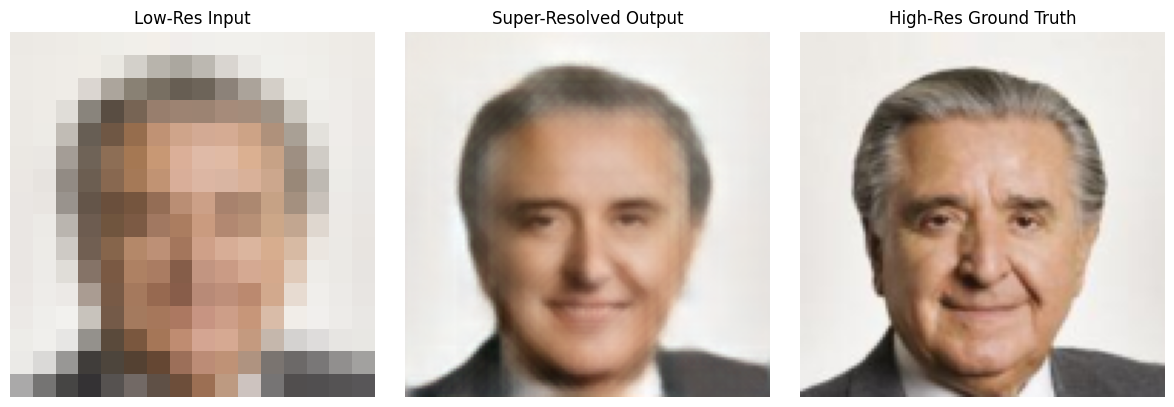

In [ ]:
# 3. Run inference on one batch from your validation loader
full_dataset = CelebDataSet(
    data_path='/kaggle/input/celeba-dataset/',
    state='val'
)

print(f"Full dataset size: {len(full_dataset)}")
dataset = Subset(full_dataset, range(18000,19000))
val_loader  = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True)

# grab one batch
x2, x4, hr, lr, heat = next(iter(val_loader))
lr, hr = lr.to(device), hr.to(device)

with torch.no_grad():
    sr = model(lr)      # <— only one output

# pick the first example
lr_cpu = lr[0].cpu()
sr_cpu = sr[0].cpu()
hr_cpu = hr[0].cpu()

# 4. Visualize input / output / target
def unnorm(x):
    return torch.clamp(x * 0.5 + 0.5, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(unnorm(lr_cpu).permute(1, 2, 0).numpy())
axes[0].set_title('Low-Res Input')
axes[1].imshow(unnorm(sr_cpu).permute(1, 2, 0).numpy())
axes[1].set_title('Super-Resolved Output')
axes[2].imshow(unnorm(hr_cpu).permute(1, 2, 0).numpy())
axes[2].set_title('High-Res Ground Truth')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()
